## US Census Data Analysis

In [15]:
## Imports Libraries

# preprocessing
from google.cloud import bigquery
from googleapiclient.discovery import build
import pandas as pd
import os

# data cleaning
from sklearn.impute import SimpleImputer

# data analysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# Set up authentication credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = './api-project-396215-aafaa4f6da87.json'

# Create a BigQuery client
bigquery_client = bigquery.Client()
# dataset_ref = bigquery_client.dataset('bigquery-public-data.new_york_taxi_trips')

In [4]:
# Construct a query
query = """
SELECT * 
FROM `bigquery-public-data.census_bureau_acs.blockgroup_2010_5yr` 
ORDER BY RAND()
LIMIT 10000
"""

# Execute the query
query_job = bigquery_client.query(query)
results = query_job.result()

In [5]:
# Store the results in a pandas DataFrame
data = []
for row in results:
    data.append(row._xxx_values)

In [35]:
# loads the DataFrame from BigData Query
columns = [key for key in row._xxx_field_to_index]
df = pd.DataFrame(data, columns=columns)

In [42]:
# loads the DataFrame from .csv file
df = pd.read_csv('./data/us_census_acs.csv')

DATA CLEANING

In [43]:
# 1. remove columns with 70%+ null values
null_column_percentages = df.isna().mean() * 100
columns_to_drop = null_column_percentages > 70
df = df.drop(columns=df.columns[columns_to_drop])

In [44]:
# 2. remove rows with 20%+ null values
null_row_percentages = df.isna().mean(axis=1) * 100
rows_to_drop = null_row_percentages > 20
df = df.drop(index=df[rows_to_drop].index)

In [21]:
# 3. remove columns with 70%+ zero values
zero_column_percentages = (df == 0).mean() * 100
columns_to_drop = zero_column_percentages > 70
df = df.drop(columns=df.columns[columns_to_drop])

In [45]:
# 4. Impute the Data

# Split the DataFrame into numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Impute numerical columns with mean
if len(numerical_cols) > 0:
    numerical_imputer = SimpleImputer(strategy='mean')
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Impute categorical columns with most frequent value
if len(categorical_cols) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

DATA ANALYSIS

In [57]:
# partition_df = df[["white_pop", "black_pop", "asian_pop", "hispanic_pop", "amerindian_pop", "other_race_pop", "two_or_more_races_pop", "median_income"]]
partition_df = df[["black_pop", "asian_pop", "median_income", "married_households"]]

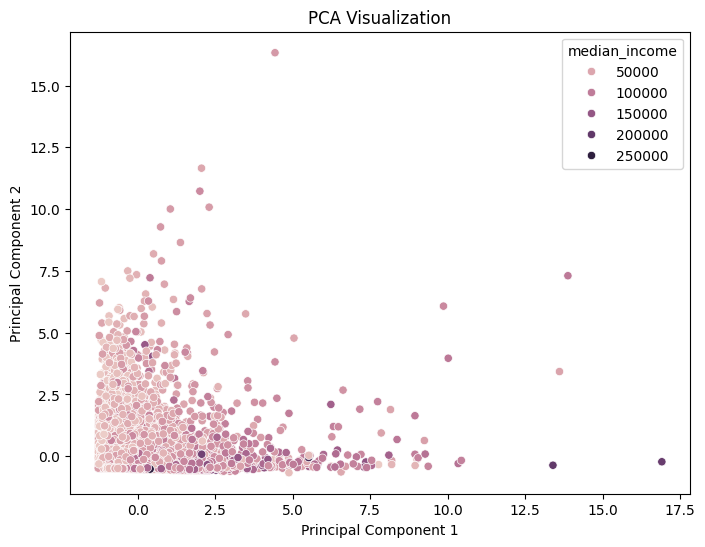

In [58]:
# Separate features and target variables
target_variable = 'median_income'
X = partition_df.drop(target_variable, axis=1)
y = partition_df[target_variable]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 principal components
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with principal components and target variable
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df = pd.concat([pca_df, y], axis=1)

# Visualize the results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue=target_variable, data=pca_df)
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Optional df save

In [39]:
# Save the DataFrame to a CSV file
data_dir = './data/'
os.makedirs(data_dir, exist_ok=True)
df.to_csv(os.path.join(data_dir, 'us_census_acs.csv'), index=False)